In [ ]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import model_selection, metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pointbiserialr, chi2_contingency, spearmanr, entropy
from statsmodels.graphics.gofplots import qqplot
from collections import Counter
from sklearn.metrics import mean_squared_error

from datetime import datetime

from tabulate import tabulate

import prince

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [ ]:
df = pd.read_csv("fraud_detection_dataset.csv", encoding= "unicode_escape")
print(df.head())

  account_open_date  age     location occupation  income_level  fico_score  \
0         11/9/2023   56  Los Angeles    Teacher         40099       424.0   
1         9/11/2022   69     New York   Engineer          2050       483.0   
2         7/12/2020   46        Miami   Engineer         71936       566.0   
3         8/13/2024   32      Houston     Banker         15833         NaN   
4         7/27/2024   60      Houston     Lawyer          8574       787.0   

   delinquency_status  charge_off_status  number_of_credit_applications  \
0                 108               True                             10   
1                   0              False                              1   
2                   0              False                              1   
3                  97               True                              5   
4                   0              False                              1   

   debt_to_income_ratio  ...  number_of_delinquent_accounts  \
0              3.

In [ ]:
df.shape

(7000, 23)

In [ ]:
column_datatypes = df.dtypes
for (columnName, columnData) in column_datatypes.items():
    print(columnName)
    print(' : ', columnData)

account_open_date
 :  object
age
 :  int64
location
 :  object
occupation
 :  object
income_level
 :  int64
fico_score
 :  float64
delinquency_status
 :  int64
charge_off_status
 :  bool
number_of_credit_applications
 :  int64
debt_to_income_ratio
 :  float64
payment_methods_high_risk
 :  bool
max_balance
 :  float64
avg_balance_last_12months
 :  float64
number_of_delinquent_accounts
 :  float64
number_of_defaulted_accounts
 :  int64
earliest_credit_account
 :  object
recent_trade_activity
 :  object
new_accounts_opened_last_12months
 :  int64
multiple_applications_short_time_period
 :  bool
unusual_submission_pattern
 :  object
applications_submitted_during_odd_hours
 :  bool
watchlist_blacklist_flag
 :  bool
public_records_flag
 :  bool


In [ ]:
df["account_open_date"] = pd.to_datetime(df["account_open_date"], format='%m/%d/%Y')
df["earliest_credit_account"] = pd.to_datetime(df["earliest_credit_account"], format='%m/%d/%Y')
df["recent_trade_activity"] = pd.to_datetime(df["recent_trade_activity"], format='%m/%d/%Y')

In [ ]:
column_datatypes = df.dtypes
for (columnName, columnData) in column_datatypes.items():
    print(columnName)
    print(' : ', columnData)

account_open_date
 :  datetime64[ns]
age
 :  int64
location
 :  object
occupation
 :  object
income_level
 :  int64
fico_score
 :  float64
delinquency_status
 :  int64
charge_off_status
 :  bool
number_of_credit_applications
 :  int64
debt_to_income_ratio
 :  float64
payment_methods_high_risk
 :  bool
max_balance
 :  float64
avg_balance_last_12months
 :  float64
number_of_delinquent_accounts
 :  float64
number_of_defaulted_accounts
 :  int64
earliest_credit_account
 :  datetime64[ns]
recent_trade_activity
 :  datetime64[ns]
new_accounts_opened_last_12months
 :  int64
multiple_applications_short_time_period
 :  bool
unusual_submission_pattern
 :  object
applications_submitted_during_odd_hours
 :  bool
watchlist_blacklist_flag
 :  bool
public_records_flag
 :  bool


In [ ]:
df_backup = df.copy()
df_backup.head()

,account_open_date,age,location,occupation,income_level,fico_score,delinquency_status,charge_off_status,number_of_credit_applications,debt_to_income_ratio,...,number_of_delinquent_accounts,number_of_defaulted_accounts,earliest_credit_account,recent_trade_activity,new_accounts_opened_last_12months,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag
0,2023-11-09,56,Los Angeles,Teacher,40099,424.0,108,True,10,3.139572,...,4.0,2,2018-09-11,2024-03-07,3,True,True,False,False,True
1,2022-09-11,69,New York,Engineer,2050,483.0,0,False,1,1.017489,...,3.0,2,2023-03-08,2024-01-28,3,False,True,False,False,False
2,2020-07-12,46,Miami,Engineer,71936,566.0,0,False,1,1.508626,...,2.0,0,2024-04-26,2024-10-03,2,False,False,False,False,False
3,2024-08-13,32,Houston,Banker,15833,NaN,97,True,5,2.995150,...,3.0,1,2023-09-14,2024-10-14,4,False,True,True,False,False
4,2024-07-27,60,Houston,Lawyer,8574,787.0,0,False,1,1.182380,...,NaN,0,2022-11-08,2024-09-02,0,True,False,True,False,False


In [ ]:
numerical_data = df.select_dtypes(include=['number'])
numerical_cols = numerical_data.columns.tolist()
categorical_data = df.select_dtypes(exclude=['number'])
categorical_cols = categorical_data.columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['age', 'income_level', 'fico_score', 'delinquency_status', 'number_of_credit_applications', 'debt_to_income_ratio', 'max_balance', 'avg_balance_last_12months', 'number_of_delinquent_accounts', 'number_of_defaulted_accounts', 'new_accounts_opened_last_12months']
Categorical Columns: ['account_open_date', 'location', 'occupation', 'charge_off_status', 'payment_methods_high_risk', 'earliest_credit_account', 'recent_trade_activity', 'multiple_applications_short_time_period', 'unusual_submission_pattern', 'applications_submitted_during_odd_hours', 'watchlist_blacklist_flag', 'public_records_flag']


In [ ]:
#check for duplicates
duplicates = df[df.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [account_open_date, age, location, occupation, income_level, fico_score, delinquency_status, charge_off_status, number_of_credit_applications, debt_to_income_ratio, payment_methods_high_risk, max_balance, avg_balance_last_12months, number_of_delinquent_accounts, number_of_defaulted_accounts, earliest_credit_account, recent_trade_activity, new_accounts_opened_last_12months, multiple_applications_short_time_period, unusual_submission_pattern, applications_submitted_during_odd_hours, watchlist_blacklist_flag, public_records_flag]
Index: []

[0 rows x 23 columns]


### Handling Missing Values


In [ ]:
#finding missing values
missing_values_count = df.isnull().sum()
total_missing = df.isnull().sum().sum()
missing_percentage = (df.isnull().mean()) * 100

print("Missing Values Count Per Column:")
print(missing_values_count)
print("\nTotal Missing Values in Dataset:")
print(total_missing)
print("\nPercentage of Missing Values Per Column:")
print(missing_percentage)

Missing Values Count Per Column:
account_open_date                            0
age                                          0
location                                     0
occupation                                   0
income_level                                 0
fico_score                                 210
delinquency_status                           0
charge_off_status                            0
number_of_credit_applications                0
debt_to_income_ratio                         0
payment_methods_high_risk                    0
max_balance                                  0
avg_balance_last_12months                  350
number_of_delinquent_accounts              700
number_of_defaulted_accounts                 0
earliest_credit_account                      0
recent_trade_activity                        0
new_accounts_opened_last_12months            0
multiple_applications_short_time_period      0
unusual_submission_pattern                 910
applications_submitted_duri

In [ ]:
#drop rows with missing values
df_cleaned = df_backup.dropna()

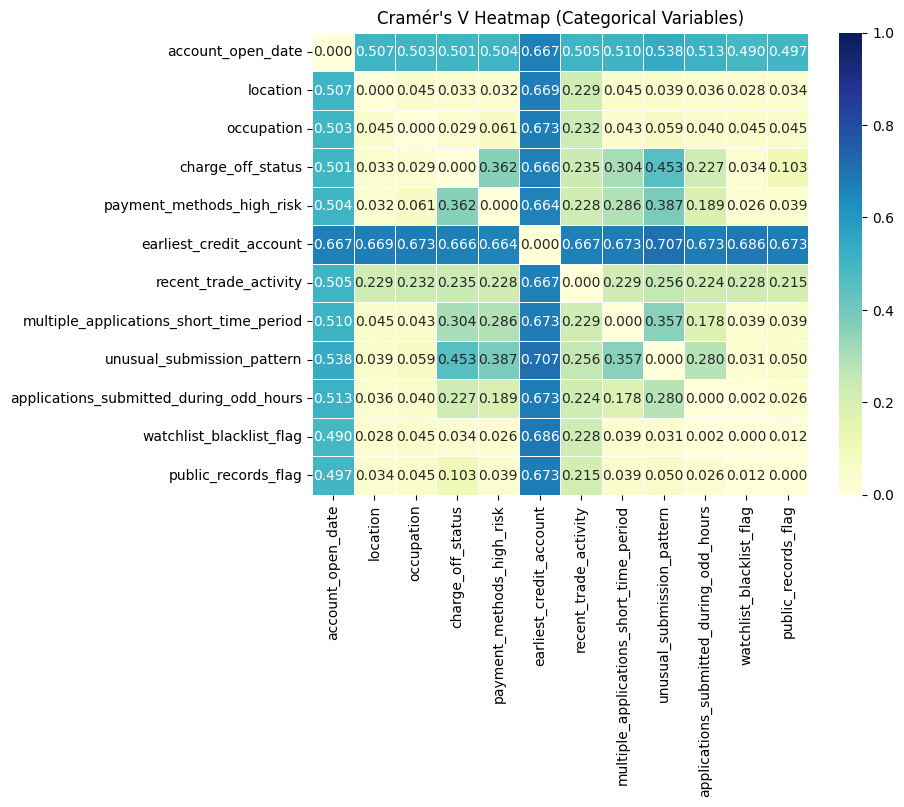

In [ ]:
#Cramér's V (categorical variables)
def cramers_v(cat1, cat2):
    contingency_table = pd.crosstab(cat1, cat2)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    cramers_v_value = np.sqrt(chi2 / (n * (min(r, k) - 1)))
    return cramers_v_value

cramers_v_matrix = np.zeros((len(categorical_cols), len(categorical_cols)))

for i, col1 in enumerate(categorical_cols):
    for j, col2 in enumerate(categorical_cols):
        if i < j:
            value = cramers_v(df[col1], df[col2])
            cramers_v_matrix[i, j] = value
            cramers_v_matrix[j, i] = value
cramers_v_df = pd.DataFrame(cramers_v_matrix, index=categorical_cols, columns=categorical_cols)


plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_df, annot=True, cmap='YlGnBu', vmin=0, vmax=1, fmt='.3f', linewidths=0.5)
plt.title("Cramér's V Heatmap (Categorical Variables)")
plt.show()

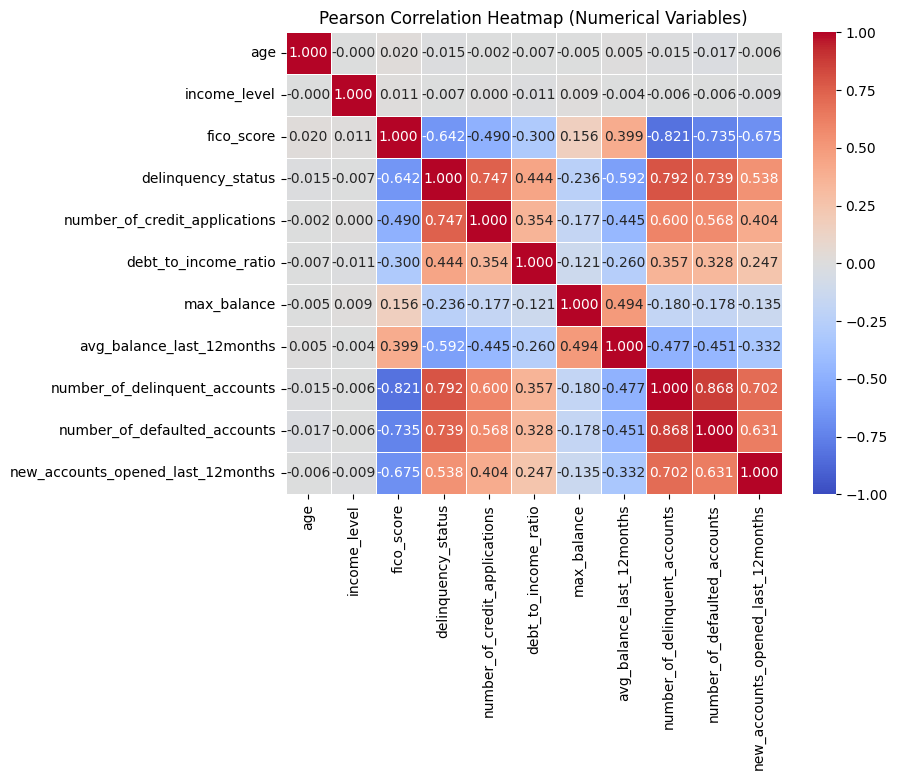

In [ ]:
#Pearson Correlation for Numerical Variables
pearson_corr = df[numerical_cols].corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.3f', linewidths=0.5)
plt.title("Pearson Correlation Heatmap (Numerical Variables)")
plt.show()

In [ ]:
#impute mean for "avg_balance_last_12months" (numerical)
numerical_imputer = SimpleImputer(strategy='mean')
df['avg_balance_last_12months'] = numerical_imputer.fit_transform(df[['avg_balance_last_12months']])

#impute mode for "unusual_submission_pattern" (categorcial)
most_frequent_value = df['unusual_submission_pattern'].mode()[0]
df['unusual_submission_pattern'].fillna(most_frequent_value, inplace=True)

In [ ]:
#fico_score and number_of_delinquent_accounts are correlated with other variables
#impute missing values using KNN

imputer = IterativeImputer(random_state=32)
#impute only fico_score, using other columns for imputation
df[["fico_score"]] = imputer.fit_transform(df[["fico_score", "number_of_delinquent_accounts", "number_of_defaulted_accounts"]])[:, 0].reshape(-1, 1)

df[["number_of_delinquent_accounts"]] = imputer.fit_transform(df[["fico_score", "delinquency_status", "number_of_defaulted_accounts", "new_accounts_opened_last_12months"]])[:, 0].reshape(-1, 1)

In [ ]:
#check for missing values now
missing_values_count = df.isnull().sum()
total_missing = df.isnull().sum().sum()
missing_percentage = (df.isnull().mean()) * 100

print("Missing Values Count Per Column:")
print(missing_values_count)
print("\nTotal Missing Values in Dataset:")
print(total_missing)
print("\nPercentage of Missing Values Per Column:")
print(missing_percentage)

Missing Values Count Per Column:
account_open_date                          0
age                                        0
location                                   0
occupation                                 0
income_level                               0
fico_score                                 0
delinquency_status                         0
charge_off_status                          0
number_of_credit_applications              0
debt_to_income_ratio                       0
payment_methods_high_risk                  0
max_balance                                0
avg_balance_last_12months                  0
number_of_delinquent_accounts              0
number_of_defaulted_accounts               0
earliest_credit_account                    0
recent_trade_activity                      0
new_accounts_opened_last_12months          0
multiple_applications_short_time_period    0
unusual_submission_pattern                 0
applications_submitted_during_odd_hours    0
watchlist_blacklist_fl

### Encoding

In [ ]:
#label encoding for columns with boolean values
columns_to_encode = ["charge_off_status", "multiple_applications_short_time_period", "unusual_submission_pattern", "applications_submitted_during_odd_hours", "watchlist_blacklist_flag", "public_records_flag", "payment_methods_high_risk"]

df[columns_to_encode] = df[columns_to_encode].applymap(lambda x: 1 if x else 0)

In [ ]:
def target_encode(df, feature, target):
    encoding_map = df.groupby(feature)[target].mean().to_dict()
    df[feature + "_encoded"] = df[feature].map(encoding_map)
    return df

df = target_encode(df, "location", "charge_off_status")
df = target_encode(df, "occupation", "charge_off_status")

### Feature Engineering - date time variables

In [ ]:
final_date = datetime(2024, 11, 30)

#days since recent activity
df["days_since_recent_trade"] = (final_date - df["recent_trade_activity"]).dt.days

#time between account opening and credit activity
df["time_between_account_open_and_trade"] = (df["recent_trade_activity"] - df["account_open_date"]).dt.days

#credit history length
df["credit_history_length"] = (df["recent_trade_activity"] - df["earliest_credit_account"]).dt.days

In [ ]:
#drop redundant columns (might be cause for multicolinearity)
df = df.drop(columns=df.select_dtypes(include=['datetime']).columns)
df = df.drop(["location", "occupation"], axis=1)

### Train Test split

In [ ]:
# train test split
X = df.drop("charge_off_status", axis=1)
y = df["charge_off_status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
print("Dimensionality of X_train:", X_train.shape)
print("Dimensionality of y_train:", y_train.shape)
print("Dimensionality of X_test:", X_test.shape)
print("Dimensionality of y_test:", y_test.shape)

Dimensionality of X_train: (5600, 22)
Dimensionality of y_train: (5600,)
Dimensionality of X_test: (1400, 22)
Dimensionality of y_test: (1400,)


In [ ]:
X_backup = df_backup.drop(columns=['charge_off_status'])
y_backup = df_backup['charge_off_status']

#20% allocated for test data and 80% for train data
X_train_backup, X_test_backup, y_train_backup, y_test_backup = train_test_split(X_backup, y_backup, test_size=0.2, random_state=32)

In [ ]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

### Checking balancedness of response variable

In [ ]:
print ('Total persons not charged with fraud :  {} and its percentage is {} %'.format(y_train.value_counts()[0], round(y_train.value_counts()[0]/y_train.value_counts().sum()*100,2)) )
print ('Total persons charged with fraud :  {} and its percentage is {} %'.format(y_train.value_counts()[1], round(y_train.value_counts()[1]/y_train.value_counts().sum()*100,2)))

Total persons not charged with fraud :  4132 and its percentage is 73.79 %
Total persons charged with fraud :  1468 and its percentage is 26.21 %


### Checking for outliers

In [ ]:
df_to_check_outliers = X_train.copy()
model = IsolationForest(contamination=0.1, random_state=32)

outliers = model.fit_predict(df_to_check_outliers)

df_to_check_outliers['outlier'] = outliers
df_to_check_outliers['outlier'] = df_to_check_outliers['outlier'].map({1: 'inlier', -1: 'outlier'})

outlier_counts = df_to_check_outliers["outlier"].value_counts()
outlier_counts

,count
outlier,
inlier,5040
outlier,560


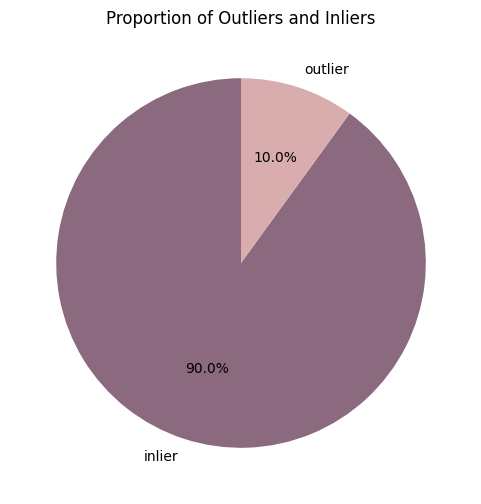

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(outlier_counts, labels=outlier_counts.index, autopct='%1.1f%%', startangle=90, colors=["#8b697e", "#d9adad"])
plt.title("Proportion of Outliers and Inliers")
plt.show()

**FAMD bc multicolinearity**

In [ ]:
n_features = X_train.shape[1]

#famd
famd = prince.FAMD(n_components=n_features)
famd = famd.fit(X_train)
inertia = famd.eigenvalues_
explained_variance = (inertia / inertia.sum())
cumulative_explained_variance = explained_variance.cumsum()
print(f"n_components = {n_features}")
print(f"Explained Variance: {explained_variance}")
print(f"Cumulative Explained Variance: {cumulative_explained_variance}")

n_components = 22
Explained Variance: [0.08014834 0.04525378 0.04491232 0.04476163 0.04456994 0.04446727
 0.04440324 0.04423141 0.04406337 0.04383567 0.04379055 0.04374203
 0.04361538 0.04353317 0.04346237 0.04342304 0.04325835 0.04309248
 0.04297429 0.04293247 0.04282729 0.04270161]
Cumulative Explained Variance: [0.08014834 0.12540213 0.17031444 0.21507607 0.25964601 0.30411328
 0.34851652 0.39274793 0.43681131 0.48064698 0.52443753 0.56817956
 0.61179494 0.65532811 0.69879048 0.74221351 0.78547186 0.82856434
 0.87153863 0.91447111 0.95729839 1.        ]


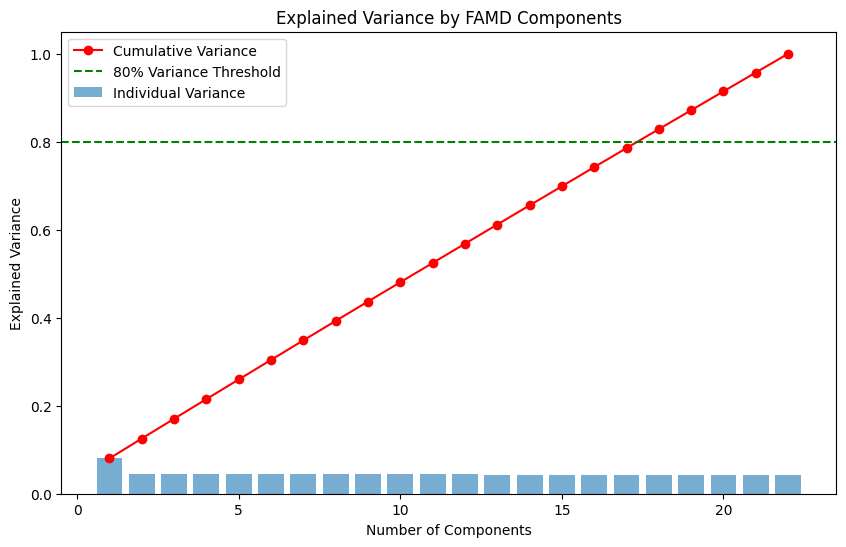

In [ ]:
#plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label="Individual Variance")
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker="o", label="Cumulative Variance", color="red")
plt.axhline(y=0.8, color="green", linestyle="--", label="80% Variance Threshold")  # Optional threshold
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("Explained Variance by FAMD Components")
plt.legend()
plt.show()

In [ ]:
optimal_components = next(i for i, total in enumerate(cumulative_explained_variance) if total >= 0.8) + 1
print(f"Optimal Number of Components: {optimal_components}")

famd_optimal = prince.FAMD(n_components=optimal_components, random_state=32)
famd_optimal = famd_optimal.fit(X_train)

reduced_data = famd_optimal.transform(X_train)

print("Reduced Data:")
print(reduced_data)

Optimal Number of Components: 18
Reduced Data:
component        0         1         2         3         4         5   \
3282       2.497973 -1.047060  2.490438 -0.126791 -6.301174  0.019172   
621       -1.772910 -5.243241 -0.205995  0.044196  1.516663  3.136831   
1204      -3.982212  1.663695 -0.556291  5.114227  2.001210  1.527200   
5587      -2.107910 -2.256931  3.282563  1.351516  3.590715 -1.413578   
5811       1.200495  1.676875 -2.378143  1.166572  2.459664 -2.177442   
...             ...       ...       ...       ...       ...       ...   
4030       1.015912 -3.473374  5.313299 -0.311549 -0.964502  1.389836   
2940      -3.720953 -2.144367  0.682480 -0.274849  3.455629 -5.282026   
1334       1.831914 -1.315395  4.424487  2.325388 -2.290249 -4.542758   
1579      -6.341145 -8.064604  3.159090 -1.747462 -4.891875  9.226902   
2775       9.349365  6.008931 -6.300184 -9.036916 -3.734730  4.927397   

component        6          7         8          9         10        11  \
3